In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             log_loss, RocCurveDisplay, PrecisionRecallDisplay,
                             DetCurveDisplay, ConfusionMatrixDisplay, brier_score_loss, classification_report, precision_recall_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from scipy.stats import chi2_contingency

In [2]:
# loading data sets
df_train = pd.read_csv('train.csv', delimiter = ';')
df_test = pd.read_csv('test.csv', delimiter = ';')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [5]:
print(f"Training Set NaNs\n{df_train.isnull().sum()}")
print(f"Test Set NaNs\n{df_test.isnull().sum()}") # checking for NaN and nulls

Training Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Test Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [6]:
# checking for 'unknown' values in categorical columns in training set
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unknown_count = (df_train[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")


job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
y: 0


In [7]:
# checking for 'unknown' values in categorical columns in test set
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        unknown_count = (df_test[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

job: 38
marital: 0
education: 187
default: 0
housing: 0
loan: 0
contact: 1324
month: 0
poutcome: 3705
y: 0


In [8]:
# exploring class distribution of dependent variable
dic = {'no': 0, 'yes': 1} # creating binary dictionary for response variable

df_train['y'] = df_train['y'].map(dic)
df_test['y'] = df_test['y'].map(dic)

In [9]:
training_conversion_rate = df_train['y'].mean()
print(f"Mean of training set response variable classes {df_train['y'].mean()}")

Mean of training set response variable classes 0.11698480458295547


In [10]:
print(f"Mean of test set response variable classes {df_test['y'].mean()}")

Mean of test set response variable classes 0.11523999115239991


In [11]:

contingency_table = pd.crosstab(df_train['job'], df_train['y']) # creating contingency table
print(contingency_table)

y                 0     1
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34


In [12]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"chi-squared statistic {chi2}")
print(f"p-value {p_value}")
print(f"df {dof}")

chi-squared statistic 836.1054877471965
p-value 3.337121944935502e-172
df 11


- Careers with above average conversion rates:
    - Students **28.7%**
    - Retired **22.8%**

- Careers with below average conversion rates:
    - Blue-collar **7.3%**
    - Entrepreneur **8.3%**

- p-value < 0.05 so reject the null that career type doesn't influence responding well to campaign

**Career type and responding positively to the campaign are dependent**

The chi-squared test (χ² = 836.11, p < 0.001) provides overwhelming evidence that job type and subscription decisions are strongly related. This suggests that profession is a critical factor in customer behavior and should be prioritized in both feature selection and business strategy."

**Feature Engineering Ideas**
- Categorize variables
    - Categorize 'month' (last contact month of the year) into Q1-Q4
        - Q1-Q4
    - Categorize 'job' into currently working or currently not working
        - Currently not working: students, retirees
        - Categories of jobs (white collar salaried jobs, blue-collared salaried jobs, variable income (entrepreneurs))
        - With these buckets I won't have to use 'education' which is probably collinear with 'job'
    - Categorize 'balance' into different buckets of wealth
    - Categorize 'day' (last contact day of the month) into buckets
        - Could learn the average time of the month people usually pay their bills or repay their debt for most banks
    - Categorize 'duration' into buckets of types of clients
    - Categorize 'campaign' (number of contacts performed during this campaign and for this client)
        - Could be buckets of frequently contacted (see if they subscribed in the past if clients were contacted more or if it bothered them into not subscribing)
        - Same for 'previous'
    - Categorize 'pdays' (number of days that passed by after the client was last contacted from a previous campaign)

1. Train baseline model with original features
2. Add engineered features incrementally
3. Compare model performance

## **Baseline Logistic Regression Model**

In [13]:
# baseline logistic regression model
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

In [14]:
cat_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
num_feats = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

In [15]:
# creating dummy variables
X_train_encoded = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [21]:
lr_baseline = LogisticRegression(max_iter=1000, 
                                random_state=42,
                                )
lr_baseline.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [23]:
pred = lr_baseline.predict(X_test_scaled)
pred_proba = lr_baseline.predict_proba(X_test_scaled)[:, 1]

In [29]:
precision = precision_score(y_test, pred)
print(f"\nPrecision: {precision:.4f}")


Precision: 0.6468


In [26]:
recall = recall_score(y_test, pred)  
print(f"\nRecall: {recall:.4f}")


Recall: 0.3340


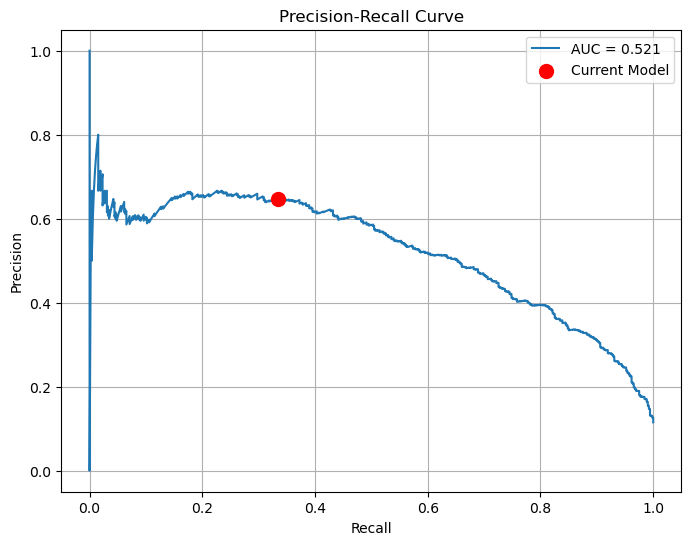

In [35]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, pred_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'AUC = {pr_auc:.3f}')
plt.scatter(recall, precision, color='red', s=100, zorder=5, label='Current Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## **Baseline K-NN Model**

In [52]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_feats)
    ])

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

pred_knn = knn_pipeline.predict(X_test)

In [56]:
# Calculate precision and recall
precision = precision_score(y_test, pred_knn, pos_label=1)
recall = recall_score(y_test, pred_knn, pos_label=1)

print("=== k-NN Model Performance ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")

=== k-NN Model Performance ===
Precision: 0.7110
Recall: 0.2975
F1-Score: 0.4195


## **Feature Engineering**

- Build baseline k-nn model with all features (and evaluate model)

- Show chi-square test results **Career type and responding positively to the campaign are dependent**
- Categorize 'month' (last contact month of the year) into Q1-Q4
- Categorize 'balance' into different buckets of wealth
- Categorize 'duration' into buckets of types of clients

- Figure out if there is multicollinearity (and how to deal with it)

- Build logistic regression model with engineered features (and evaluate model)

- Build k-nn model with engineered features (and evaluate model)

- Build logistic regression model with engineered features & balancing classes (try built-in parameter then try downsampling and upweighting majority class method) (and evaluate model)

- Build k-nn model with engineered features & balancing classes (and evaluate model)

- Build and tune 4 ensemble models (and evalute models)

- Write report 

In [ ]:
print(df_train['month'].value_counts().sort_index())

month
apr     2932
aug     6247
dec      214
feb     2649
jan     1403
jul     6895
jun     5341
mar      477
may    13766
nov     3970
oct      738
sep      579
Name: count, dtype: int64


In [ ]:
print(f"\nConversion Rate by Month: {df_train.groupby('month')['y'].mean().sort_values(ascending=False)}")
# Which months have data and their conversion rates (to create meaningful quarters)


Conversion Rate by Month: month
mar    0.519916
dec    0.467290
sep    0.464594
oct    0.437669
apr    0.196794
feb    0.166478
aug    0.110133
jun    0.102228
nov    0.101511
jan    0.101212
jul    0.090935
may    0.067195
Name: y, dtype: float64


In [49]:
print("\n" + "="*50)
print("BALANCE STATISTICS")
print("="*50)
print(df_train['balance'].describe())
print("\nBalance percentiles:")
print(df_train['balance'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(f"\nNegative balance count: {(df_train['balance'] < 0).sum()}")
print(f"Negative balance rate: {(df_train['balance'] < 0).mean():.2%}")
print("\nConversion rate by balance sign:")
print(df_train.groupby(df_train['balance'] < 0)['y'].mean())
# Balance distribution (to see if quantiles or custom buckets make more sense)


BALANCE STATISTICS
count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

Balance percentiles:
0.10        0.0
0.25       72.0
0.50      448.0
0.75     1428.0
0.90     3574.0
0.95     5768.0
0.99    13164.9
Name: balance, dtype: float64

Negative balance count: 3766
Negative balance rate: 8.33%

Conversion rate by balance sign:
balance
False    0.122548
True     0.055762
Name: y, dtype: float64


In [ ]:
print("\n" + "="*50)
print("DURATION STATISTICS")
print("="*50)
print(df_train['duration'].describe())
print("\nDuration percentiles:")
print(df_train['duration'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print("\nConversion rate by duration quartiles:")
print(df_train.groupby(pd.qcut(df_train['duration'], q=4, duplicates='drop'))['y'].mean())
# Duration patterns (to determine natural breakpoints for "client types")

In [ ]:
housing_lasso = lm.Lasso(alpha=10000).fit(x, y)
housing_lasso.coef_